Test

In [3]:
import numpy as np

from time import time

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

In [4]:
import retworkx as rx

from qiskit_nature.problems.second_quantization.lattice import Lattice

# Custom Heisenberg couplings
from heisenberg_model import HeisenbergModel

Draw the Kagome 12-site cell.

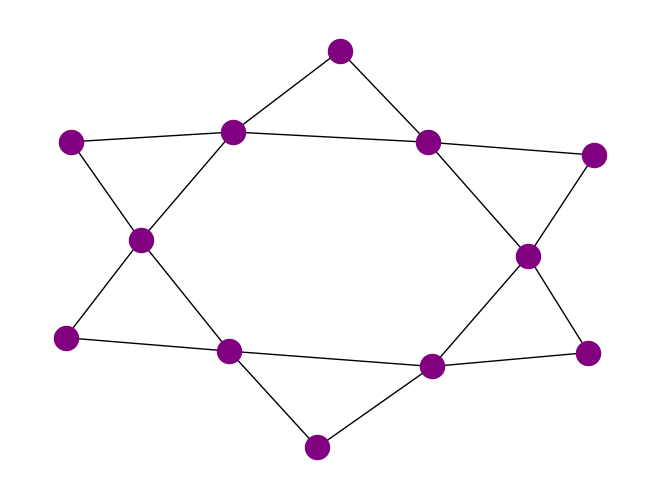

In [5]:
# Kagome unit cell
num_sites = 12
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 5, t),
    (5, 0, t),
    (0, 6, t),
    (1, 6, t),
    (1, 7, t),
    (2, 7, t),
    (2, 8, t),
    (3, 8, t),
    (3, 9, t),
    (4, 9, t),
    (4, 10, t),
    (5, 10, t),
    (5, 11, t),
    (0, 11, t),
]
# Generate graph from the list of edges
graph.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell = Lattice(graph)

# Draw Lattice
kagome_unit_cell.draw(style={'node_color':'purple'})
# plt.savefig('kagome_unit_cell.png')
plt.show()

Now that we have the lattice geometry, we can place each term in the Hamiltonian on its corresponding edge. This is done by using the custom `HeisenbergModel` found in the heisenberg_model.py file. This model is based on Qiskit Nature's [`IsingModel` class](https://qiskit.org/documentation/nature/stubs/qiskit_nature.problems.second_quantization.lattice.IsingModel.html) . It places $XX + YY + ZZ$ on each edge of the lattice (per the Hamiltonian's definition).

We will also need to specify how the spin-1/2 particles map to qubits. Using Qiskit nature's `LogarithmicMapper`, we can map each spin-1/2 site to a single qubit. For more information on Qiskit nature's spin mappings see [here]( https://qiskit.org/documentation/nature/stubs/qiskit_nature.mappers.second_quantization.SpinMapper.html#qiskit_nature.mappers.second_quantization.SpinMapper).

In [6]:
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

In [7]:
# Build Hamiltonian from graph edges
heis = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell,
    uniform_interaction=1.0,  # same spin-spin interaction weight as used in graph
    uniform_onsite_potential=0.0,  # No singe site external field
)

# The Lattice needs an explicit mapping to the qubit states.
# We map 1 qubit for 1 spin-1/2 particle using the LogarithmicMapper
log_mapper = LogarithmicMapper()
# Multiply by factor of 4 to account for (1/2)^2 terms from spin operators in the HeisenbergModel
ham = 4 * log_mapper.map(heis.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect.
# There are 18 edges and 3 terms per edge (XX, YY, and ZZ),
# so there should be 54 equally weighted terms.
ham

PauliSumOp(SparsePauliOp(['ZIIIIIZIIIII', 'IZIIIIZIIIII', 'IZIIIIIZIIII', 'IIZIIIIZIIII', 'IIIIIIZZIIII', 'IIZIIIIIZIII', 'IIIZIIIIZIII', 'IIIIIIIZZIII', 'IIIZIIIIIZII', 'IIIIZIIIIZII', 'IIIIIIIIZZII', 'IIIIZIIIIIZI', 'IIIIIZIIIIZI', 'IIIIIIIIIZZI', 'ZIIIIIIIIIIZ', 'IIIIIZIIIIIZ', 'IIIIIIZIIIIZ', 'IIIIIIIIIIZZ', 'YIIIIIYIIIII', 'IYIIIIYIIIII', 'IYIIIIIYIIII', 'IIYIIIIYIIII', 'IIIIIIYYIIII', 'IIYIIIIIYIII', 'IIIYIIIIYIII', 'IIIIIIIYYIII', 'IIIYIIIIIYII', 'IIIIYIIIIYII', 'IIIIIIIIYYII', 'IIIIYIIIIIYI', 'IIIIIYIIIIYI', 'IIIIIIIIIYYI', 'YIIIIIIIIIIY', 'IIIIIYIIIIIY', 'IIIIIIYIIIIY', 'IIIIIIIIIIYY', 'XIIIIIXIIIII', 'IXIIIIXIIIII', 'IXIIIIIXIIII', 'IIXIIIIXIIII', 'IIIIIIXXIIII', 'IIXIIIIIXIII', 'IIIXIIIIXIII', 'IIIIIIIXXIII', 'IIIXIIIIIXII', 'IIIIXIIIIXII', 'IIIIIIIIXXII', 'IIIIXIIIIIXI', 'IIIIIXIIIIXI', 'IIIIIIIIIXXI', 'XIIIIIIIIIIX', 'IIIIIXIIIIIX', 'IIIIIIXIIIIX', 'IIIIIIIIIIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j

### Compute ground state energy
With the Hamiltonian in hand, we can now calculate the expected ground state and its energy. Qiskit offers different methods to do this. The method [here](https://qiskit.org/documentation/apidoc/algorithms.html#minimum-eigensolvers) computes the ground state energy. This [method](https://qiskit.org/documentation/apidoc/algorithms.html#eigensolvers) computes the ground state ($k=0$) and potentially higher energy states if the users wishes ($k>0$).

Below is an example calculation of finding the lowest 3 energies ($k=3$) of the system using the second method. Remember that for this year's Prize, you will only need to use VQE to find the ground state energy and not any excited state energies.

In [8]:
from qiskit.algorithms import NumPyEigensolver

# find the first three (k=3) eigenvalues
exact_solver = NumPyEigensolver(k=3)
exact_result = exact_solver.compute_eigenvalues(ham)
print(exact_result.eigenvalues)

# Save ground state energy for later
gs_energy = np.round(exact_result.eigenvalues[0], 4)

[-18.         -18.         -16.96132284]


You'll note that -18 is found twice. This means there are actually two ground states for this system. The -16.96 energy is the first excited state, which is not part of this year's challenge. **For this year's Prize, we will only be judging based off the measured ground state energy. This means it does not matter which of the two ground states, or combination of them, your VQE implementation finds.**

## 2-1 VQE with local runtime primitives

To compute the ground state energy using VQE, we first pick an appropriate device. This year's Prize will use ibmq_guadalupe which has 16 qubits. This is 4 extra qubits than the Hamiltonian, so we will need to "inflate" the Hamiltonian with identity operators so we can measure 12 qubit Hamiltonian's energy expectation value on a 16 qubit device.
After inflating the Hamiltonian, the anstaz and classical optimizer components are built up. Finally, a class is defined to bring everything together for the VQE algorithm, and it's executed on a local simulator.

The code below is largely based off of this example [tutorial](https://github.com/mberna/qce22-qiskit-runtime-tutorial/blob/main/docs/tutorials/Building%20algorithms%20with%20Qiskit%20Runtime.ipynb) of using qiskit runtime primitives from IEEE week. Feel free to read through to learn more about qiskit runtime and VQE.

## 2-2 Qiskit runtime

[Qiskit runtime](https://github.com/Qiskit/qiskit-ibm-runtime) is a paradigm which brings classical and quantum computing resources closer together--speeding up quantum algorithms especially variational ones. We will be using runtime because of its [speed boost](https://research.ibm.com/blog/120x-quantum-speedup) relative to the traditional way quantum circuits are executed using qiskit. In this notebook, we'll demonstrate an example VQE executed with qiskit runtime, but we encourage you to get a deeper understanding of the tool by checking out an overview of qiskit runtime and some tutorials on the [qiskit docs section on runtime](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) as well as the IBM [research blog](https://research.ibm.com/blog/qiskit-runtime-capabilities-integration).

In [9]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

from qiskit import IBMQ

In [14]:
# Doc for loading IBMQ account https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq#the-account
# IBMQ.save_account(TOKEN)
provider = IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
from qiskit.providers.fake_provider import FakeGuadalupe
# Real backend; needed for transpilation later on

#guadalupe = provider.get_backend("ibmq_guadalupe")

# Get fake backend if you like
#from qiskit.providers.fake_provider import FakeGuadalupe

# Noisy simulator backend
noisy_sim = FakeGuadalupe()

ibmqfactory.load_account:WARNING:2023-01-18 12:44:50,100: Credentials are already in use. The existing account in the session will be replaced.


As mentioned at the beginning of this section, the system Hamiltonian is defined over 12 qubits, but ibmq_guadalupe has 16 qubits. To execute VQE on ibmq_guadalupe, we will "inflate" the Hamilontian from 12 qubits to 16 qubits to match ibmq_guadalupe, but those extra 4 qubits will not participate in the energy expectation value. Here, we've chosen the 4 qubits that won't participate to be 0, 6, 9, 15. You may pick different qubits.

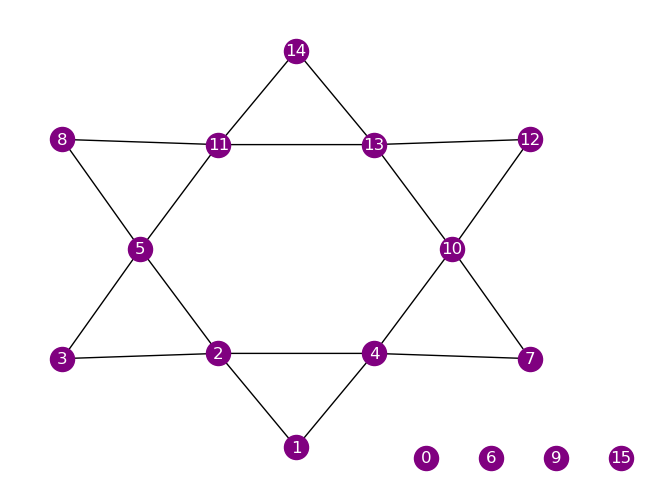

In [15]:
# Kagome unit cell
num_qubits = 16
# Edge weight
t = 1.0

# Generate graph of kagome unit cell
# Start by defining all the edges
graph_16 = rx.PyGraph(multigraph=False)
graph_16.add_nodes_from(range(num_qubits))
edge_list = [
    (1, 2, t),
    (2, 3, t),
    (3, 5, t),
    (5, 8, t),
    (8, 11, t),
    (11, 14, t),
    (14, 13, t),
    (13, 12, t),
    (12, 10, t),
    (10, 7, t),
    (7, 4, t),
    (4, 1, t),
    (4, 2, t),
    (2, 5, t),
    (5, 11, t),
    (11, 13, t),
    (13, 10, t),
    (10, 4, t),
]
# Generate graph from the list of edges
graph_16.add_edges_from(edge_list)

# Make a Lattice from graph
kagome_unit_cell_16 = Lattice(graph_16)

# Draw Lattice and include labels to check we exclude the right spins
# Specify node locations for better visualizations
kagome_pos = {0:[1,-1], 6:[1.5,-1], 9:[2,-1], 15:[2.5,-1], 
              1:[0,-0.8], 2:[-0.6,1], 4:[0.6,1], 10:[1.2,3], 
              13:[0.6,5], 11:[-0.6,5], 5:[-1.2,3], 3:[-1.8,0.9], 
              8:[-1.8,5.1], 14:[0,6.8], 7:[1.8,0.9], 12:[1.8,5.1]}
kagome_unit_cell_16.draw(style={'with_labels':True, 'font_color':'white', 'node_color':'purple', 'pos':kagome_pos})
plt.show()

In [16]:
# Build Hamiltonian from graph edges
heis_16 = HeisenbergModel.uniform_parameters(
    lattice=kagome_unit_cell_16,
    uniform_interaction=t,
    uniform_onsite_potential=0.0,  # No singe site external field
)

# Map from SpinOp to qubits just as before.
log_mapper = LogarithmicMapper()
ham_16 = 4 * log_mapper.map(heis_16.second_q_ops().simplify())
# Print Hamiltonian to check it's what we expect:
# 18 ZZ, 18 YY, and 18 XX terms over 16 qubits instead of over 12 qubits
ham_16
#this is the inflated hamiltonian, used to measure the energy of the system

PauliSumOp(SparsePauliOp(['IZZIIIIIIIIIIIII', 'IIZZIIIIIIIIIIII', 'IZIIZIIIIIIIIIII', 'IIZIZIIIIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIIZIZIIIIIIIIII', 'IIIIZIIZIIIIIIII', 'IIIIIZIIZIIIIIII', 'IIIIZIIIIIZIIIII', 'IIIIIIIZIIZIIIII', 'IIIIIZIIIIIZIIII', 'IIIIIIIIZIIZIIII', 'IIIIIIIIIIZIZIII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIIIZIZII', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIIIIZZI', 'IYYIIIIIIIIIIIII', 'IIYYIIIIIIIIIIII', 'IYIIYIIIIIIIIIII', 'IIYIYIIIIIIIIIII', 'IIYIIYIIIIIIIIII', 'IIIYIYIIIIIIIIII', 'IIIIYIIYIIIIIIII', 'IIIIIYIIYIIIIIII', 'IIIIYIIIIIYIIIII', 'IIIIIIIYIIYIIIII', 'IIIIIYIIIIIYIIII', 'IIIIIIIIYIIYIIII', 'IIIIIIIIIIYIYIII', 'IIIIIIIIIIYIIYII', 'IIIIIIIIIIIYIYII', 'IIIIIIIIIIIIYYII', 'IIIIIIIIIIIYIIYI', 'IIIIIIIIIIIIIYYI', 'IXXIIIIIIIIIIIII', 'IIXXIIIIIIIIIIII', 'IXIIXIIIIIIIIIII', 'IIXIXIIIIIIIIIII', 'IIXIIXIIIIIIIIII', 'IIIXIXIIIIIIIIII', 'IIIIXIIXIIIIIIII', 'IIIIIXIIXIIIIIII', 'IIIIXIIIIIXIIIII', 'IIIIIIIXIIXIIIII', 'IIIIIXIIIIIXIIII', 'IIIIIIIIXIIXIIII', 'IIIIIIIIIIXIX

## 2-3 Define an ansatz
Crafting the ansatz is critical to VQE. We will make our own custom ansatz. Keep in mind that a custom ansatz should have no measurement gates at the end. The circuit parameters are defined by using `Parameter()` [objects](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html). Define anstaz only on the 12 qubits, no need to specify the 4 idle ones.

Below is an example of building a custom ansatz.

In [17]:
# Build a custom ansatz from scratch
ansatz_custom = QuantumCircuit(12)
# build initial state
ansatz_custom.h(range(0, 12, 2))
ansatz_custom.cx(range(0, 11, 2), range(1, 12, 2))
# First layer
j = 0
for i in range(12):
    ansatz_custom.rz(Parameter('θ_' + str(j)), i)
    j += 1
    ansatz_custom.ry(Parameter('θ_' + str(j)), i)
    j += 1
ansatz_custom.cx(range(0, 11), range(1, 12))

ansatz_custom.draw(fold=250)

┌───┐     ┌─────────┐ ┌─────────┐                                                        
 q_0: ┤ H ├──■──┤ Rz(θ_0) ├─┤ Ry(θ_1) ├───■────────────────────────────────────────────────────
      └───┘┌─┴─┐├─────────┤ ├─────────┤ ┌─┴─┐                                                  
 q_1: ─────┤ X ├┤ Rz(θ_2) ├─┤ Ry(θ_3) ├─┤ X ├──■───────────────────────────────────────────────
      ┌───┐└───┘├─────────┤ ├─────────┤ └───┘┌─┴─┐                                             
 q_2: ┤ H ├──■──┤ Rz(θ_4) ├─┤ Ry(θ_5) ├──────┤ X ├──■──────────────────────────────────────────
      └───┘┌─┴─┐├─────────┤ ├─────────┤      └───┘┌─┴─┐                                        
 q_3: ─────┤ X ├┤ Rz(θ_6) ├─┤ Ry(θ_7) ├───────────┤ X ├──■─────────────────────────────────────
      ┌───┐└───┘├─────────┤ ├─────────┤           └───┘┌─┴─┐                                   
 q_4: ┤ H ├──■──┤ Rz(θ_8) ├─┤ Ry(θ_9) ├────────────────┤ X ├──■────────────────────────────────
      └───┘┌─┴─┐├─────────┴┐├─────────┴┐               └───┘┌─┴─┐                              
 q_5: ─────┤ X ├┤ Rz(θ_10) ├┤ Ry(θ_11) ├────────────────────┤ X ├──■───────────────────────────
      ┌───┐└───┘├──────────┤├──────────┤                    └───┘┌─┴─┐                         
 q_6: ┤ H ├──■──┤ Rz(θ_12) ├┤ Ry(θ_13) ├─────────────────────────┤ X ├──■──────────────────────
      └───┘┌─┴─┐├──────────┤├──────────┤                         └───┘┌─┴─┐                    
 q_7: ─────┤ X ├┤ Rz(θ_14) ├┤ Ry(θ_15) ├──────────────────────────────┤ X ├──■─────────────────
      ┌───┐└───┘├──────────┤├──────────┤                              └───┘┌─┴─┐               
 q_8: ┤ H ├──■──┤ Rz(θ_16) ├┤ Ry(θ_17) ├───────────────────────────────────┤ X ├──■────────────
      └───┘┌─┴─┐├──────────┤├──────────┤                                   └───┘┌─┴─┐          
 q_9: ─────┤ X ├┤ Rz(θ_18) ├┤ Ry(θ_19) ├────────────────────────────────────────┤ X ├──■───────
      ┌───┐└───┘├──────────┤├──────────┤                                        └───┘┌─┴─┐     
q_10: ┤ H ├──■──┤ Rz(θ_20) ├┤ Ry(θ_21) ├─────────────────────────────────────────────┤ X ├──■──
      └───┘┌─┴─┐├──────────┤├──────────┤                                             └───┘┌─┴─┐
q_11: ─────┤ X ├┤ Rz(θ_22) ├┤ Ry(θ_23) ├──────────────────────────────────────────────────┤ X ├
           └───┘└──────────┘└──────────┘                                                  └───┘

### Match qubit layout
The ansatz is currently defined over 12 qubits, but it will be executed on guadalupe which has 16 qubits. To make the ansatz compatible with guadalupe and the inflated Hamiltonian, we can specify the qubit layout on the real device using the transpiler (shown below). We exclude the four qubits with fewest neighbors.

In [18]:
# Force anstaz to be applied to qubits in the heavy hex.
# Avoid the outer qubits 0, 6, 9, and 15 which we accounted for in the lattice definition. (dangling qubits of IBM Guadalupe)
q_layout = [1, 2, 3, 5, 8, 11, 14, 13, 12, 10, 7, 4]
ansatz_opt = transpile(ansatz_custom, backend=noisy_sim, initial_layout=q_layout)
#backend is the device - i.e. guadalupe (or FakeGuadalupe for sims)

print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
ansatz_opt.draw(fold=300)

number and type of gates in the cirucit: OrderedDict([('rz', 48), ('sx', 30), ('cx', 17)])
number of parameters in the circuit: 24


global phase: 3π/2
                                                                                                                                                                               
 ancilla_0 -> 0 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                ┌─────────┐┌────┐┌─────────┐     ┌─────────┐    ┌────┐   ┌─────────────┐      ┌────┐     ┌────────┐                                                            
       q_0 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──■──┤ Rz(θ_0) ├────┤ √X ├───┤ Rz(θ_1 + π) ├──────┤ √X ├─────┤ Rz(3π) ├────■───────────────────────────────────────────────────────
                └─────────┘└────┘└─────────┘┌─┴─┐├─────────┤    ├────┤   ├─────────────┤      ├────┤     ├────────┤  ┌─┴─┐                                                     
       q_1 -> 2 ────────────────────────────┤ X ├┤ Rz(θ_2) ├────┤ √X ├───┤ Rz(θ_3 + π) ├──────┤ √X ├─────┤ Rz(3π) ├──┤ X ├─────■───────────────────────────────────────────────
                ┌─────────┐┌────┐┌─────────┐└───┘├─────────┤    ├────┤   ├─────────────┤      ├────┤     ├────────┤  └───┘   ┌─┴─┐                                             
       q_2 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──■──┤ Rz(θ_4) ├────┤ √X ├───┤ Rz(θ_5 + π) ├──────┤ √X ├─────┤ Rz(3π) ├──────────┤ X ├──■──────────────────────────────────────────
                └─────────┘└────┘└─────────┘  │  └──┬───┬──┘ ┌──┴────┴──┐└────┬────┬───┘ ┌────┴────┴────┐└─┬────┬─┘┌────────┐└───┘  │                                     ┌───┐
      q_11 -> 4 ──────────────────────────────┼─────┤ X ├────┤ Rz(θ_22) ├─────┤ √X ├─────┤ Rz(θ_23 + π) ├──┤ √X ├──┤ Rz(3π) ├───────┼─────────────────────────────────────┤ X ├
                                            ┌─┴─┐   └─┬─┘    ├─────────┬┘     ├────┤     ├─────────────┬┘  ├────┤  ├────────┤     ┌─┴─┐                                   └─┬─┘
       q_3 -> 5 ────────────────────────────┤ X ├─────┼──────┤ Rz(θ_6) ├──────┤ √X ├─────┤ Rz(θ_7 + π) ├───┤ √X ├──┤ Rz(3π) ├─────┤ X ├──■──────────────────────────────────┼──
                                            └───┘     │      └─────────┘      └────┘     └─────────────┘   └────┘  └────────┘     └───┘  │                                  │  
 ancilla_1 -> 6 ──────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────┼──
                ┌─────────┐┌────┐┌─────────┐          │      ┌──────────┐     ┌────┐     ┌──────────────┐  ┌────┐  ┌────────┐            │                           ┌───┐  │  
      q_10 -> 7 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──────────■──────┤ Rz(θ_20) ├─────┤ √X ├─────┤ Rz(θ_21 + π) ├──┤ √X ├──┤ Rz(3π) ├────────────┼───────────────────────────┤ X ├──■──
                ├─────────┤├────┤├─────────┤     ┌─────────┐ └──┬────┬──┘┌────┴────┴───┐ └────┬────┬────┘┌─┴────┴─┐└────────┘          ┌─┴─┐                         └─┬─┘     
       q_4 -> 8 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──■──┤ Rz(θ_8) ├────┤ √X ├───┤ Rz(θ_9 + π) ├──────┤ √X ├─────┤ Rz(3π) ├────────────────────┤ X ├──■────────────────────────┼───────
                └─────────┘└────┘└─────────┘  │  └─────────┘    └────┘   └─────────────┘      └────┘     └────────┘                    └───┘  │                        │       
 ancilla_2 -> 9 ──────────────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────┼────────────────────────┼───────
                                              │     ┌───┐    ┌──────────┐     ┌────┐     ┌──────────────┐  ┌────┐  ┌────────┐                 │                 ┌───┐  │       
      q_9 -> 10 ──────────────────────────────┼─────┤ X ├────┤ Rz(θ_18) ├─────┤ √X ├─────┤ Rz(θ_19 + π) ├──┤ √X ├──┤ Rz(3π) ├─────────────────┼─────────────────┤ X ├──■───────
                                            ┌─┴─┐   └─┬─┘    ├──────────┤     ├────┤     ├──────────────┤  ├─

## 2-(4,5) Define custom VQE program
Select a [classical optimizer](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html#local-optimizers). The classical optimizer will encounter errored and stochastic results from the quantum computer due to gate errors, measurement errors, and other noise sources as well as finite sampling affects [8]. 

NOTE: This is likely where a significant amount of improvement can be done. Fast-slow methods seem to be optimal (greedy + genetic?). Another important aspect is the setting of the random initial state - can get stuck in a barren plateau.

\[8\] "Using models to improve optimizers for variational quantum algorithms" K. Sung, et al. [arXiv:2005.11011v2](https://arxiv.org/abs/2005.11011v2) [quant-ph] (2020)

The VQE calculation is then efficiently orchestrated between the quantum and classical computer using qiskit's [primitives](https://qiskit.org/documentation/apidoc/primitives.html).This creates a custom class which is called `CustomVQE`.

In [21]:
from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit.algorithms.optimizers import SPSA

#define the classical optimizer
optimizer = SPSA(maxiter=75)

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

#It's important to know what's going on between the classical and quantum computer during the optimization. 
#What parameter values is the classical optimizer picking? How does the convergence to the ground state energy behave?
#this gives access to that
intermediate_info = []
def callback(value):
        intermediate_info.append(value)


## 2-6 Execute simulated VQE
The VQE is built! Time to test it out on a simulator. This may take a few seconds.

In [22]:
from qiskit.primitives import Estimator

In [23]:
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [ham_16])

# Setup VQE algorithm
custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time()
result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()

print(result)
print(f'execution time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 150,
    'eigenstate': None,
    'eigenvalue': -6.428648451275276,
    'optimal_circuit': None,
    'optimal_parameters': array([-1.13301986,  0.72923529, -0.96164282, -2.99088415, -3.80798536,
       -2.07165686, -2.52777563,  1.01320671,  4.4596963 ,  3.13248774,
       -0.2064998 , -0.03408024, -0.11025636, -1.90405218,  5.15253378,
       -1.87500097, -2.58036477, -4.13204232,  1.41338535, -2.83564835,
        1.42706725, -0.31190709,  0.10324349,  6.35693061]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 17.91


Through the callback function, plot the energy convergence data as a function of iterations of the classical optimizer.

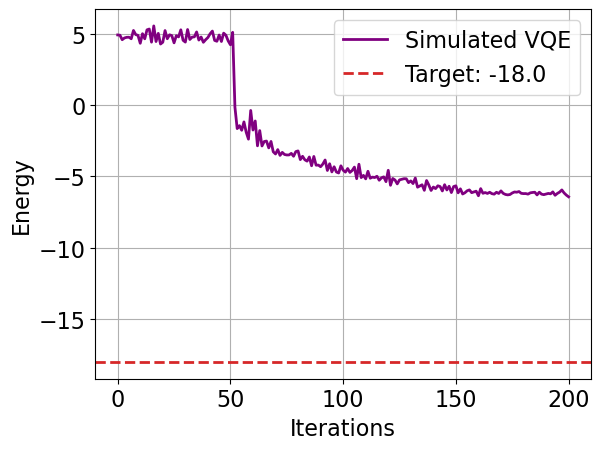

In [24]:
plt.plot(intermediate_info, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
# Exact ground state energy value
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

## 3-1 Qiskit runtime (cloud simulator)

Next we demonstrate how to run VQE using [qiskit_ibm_runtime](https://github.com/Qiskit/qiskit-ibm-runtime) **which has different syntax from qiskit terra's runtime**. The qiskit_ibm_runtime module includes the same programming model as qiskit terra, but qiskit_ibm_runtime has access to a cloud simulator and more importantly the ibmq_guadalupe device. To learn more about qiskit_ibm_runtime check out these tutorials from the docs: [a tutorial on the estimator](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/tutorials/how-to-getting-started-with-estimator.ipynb) and [a tutorial on the sampler](https://github.com/Qiskit/qiskit-ibm-runtime/blob/main/docs/tutorials/how-to-getting-started-with-sampler.ipynb).

We will use all the same VQE components we've built up so far, but the syntax for executing on the hardware is wrapped in [a session](https://quantum-computing.ibm.com/lab/docs/iql/manage/systems/sessions/) as shown in the following cells.

We first demonstrate running VQE with the cloud simulator backend to check everything is working correctly. This may take a few minutes. After running on the cloud simulator, we make a simple switch of backends to the real ibmq_guadalupe device to get the final result. Depending on how your VQE is setup, this may take a couple hours.

In [27]:
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit import Aer

# Save an IBM Quantum account. See docs for credential security warning
# https://github.com/Qiskit/qiskit-ibm-runtime/tree/stable/0.7#saving-account-on-disk
#QiskitRuntimeService.save_account(channel="ibm_quantum", token="mytoken")
service = QiskitRuntimeService(channel='ibm_quantum')

In [28]:
# print available backend and select one
print('Simulators:', service.backends(simulator=True))

# Select a simulator backend
backend = 'simulator_statevector'

Simulators: [<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_stabilizer')>]


In [29]:
# Define a simple callback function
intermediate_info_sim_backend = []
def callback_sim(value):
        intermediate_info_sim_backend.append(value)

In [30]:
# Setup Estimator
start = time()
with Session(service=service, backend=backend) as session:
    # Prepare primitive
    rt_estimator = RuntimeEstimator(session=session)
    # Set up algorithm
    custom_vqe = CustomVQE(rt_estimator, ansatz_opt, optimizer, callback=callback_sim)
    # Run algorithm
    result = custom_vqe.compute_minimum_eigenvalue(ham_16)
end = time()
print(f'execution time (s): {end - start:.2f}')

execution time (s): 1208.94


Things that can be changed in the above qiskit_runtime_simulator. 
- different ansatz_opt circuit. 
- choice of the classical optimizer
- ham_16 and its structure on the Guadalupe device.
- include error mitigation techniques

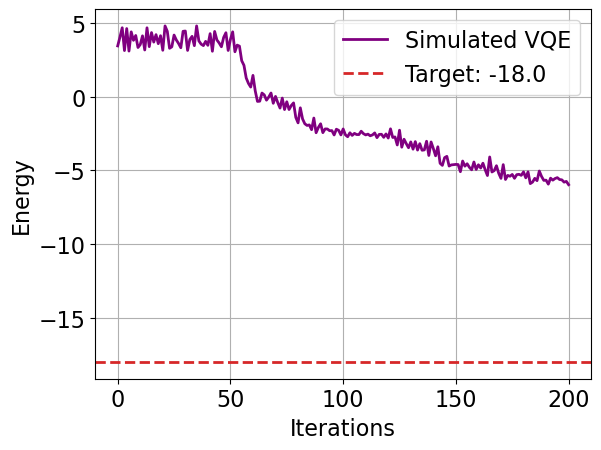

In [31]:
plt.plot(intermediate_info_sim_backend, color='purple', lw=2, label='Simulated VQE')
plt.ylabel('Energy')
plt.xlabel('Iterations')
plt.axhline(y=gs_energy, color="tab:red", ls="--", lw=2, label="Target: " + str(gs_energy))
plt.legend()
plt.grid()
plt.show()

In [33]:
# Compute the relative error between the expected ground state energy and the measured
gs_energy = -18
rel_error = np.abs((gs_energy - result.eigenvalue)/gs_energy)

print(f'Expected ground state energy: {gs_energy:.10f}')
print(f'Computed ground state energy: {result.eigenvalue:.10f}')
print(f'Relative error: {rel_error:.8f}')

Expected ground state energy: -18.0000000000
Computed ground state energy: -5.9710000000
Relative error: 0.66827778


For further information as to how to use the real ibm_guadalupe device as a backend, look to the other notebook.

# Considerations
Feeling stuck? Below are a list of questions and considerations to help spark new ideas for your VQE implementation.

**Ansatz.** Carefully consult research literature for the best approach of ansatz selection. How might errors affect your ansatz? How many parameters are needed to reach the ground state? What properties of the Hamiltonian could help simplify the ansatz?

**Classical optimizer.** What optimizer will pair well with for your choice of ansatz and measurement parameters? What noise do you expect from the quantum computer, and what noise sensitivity can the classical optimizer withstand? How many iterations will be needed?

**Initial state/point.** Is there an initial quantum state that really helps things get going? What about a starting point for the circuit parameters? Does the VQE give the same results for different initial parameter values?

**Number of measurements.** How does the number of shots affect the VQE's convergence to the ground state energy? The expectation value of the Hamiltonian is a sum of the expectation values of each of the 54 terms. What is the least number of circuit executions necessary to compute the expectation value of the Hamiltonian? What is the optimal number of circuit executions for stable convergence?

**Many qubits.** Working with larger numbers of qubits is its own challenge. For example, what's a concise way of writing down or even visualizing the 4096 digit ground state? What methods and techniques will not scale well? What techniques would scale well if this VQE were to be done on a larger system? How can you reduce your execution time of the real device?

**Error mitigation.** What errors are most prevalent, and how can you reduce them efficiently? What error mitigation techniques will scale well?